In [3]:
import psycopg2
import pandas as pd
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pytz
import pandas_ta as ta
import plotly.express as px
import plotly.graph_objects as go
import itertools
import random
from da_controller import *
from strategies import *
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from typing import Dict, List, Any
from optimizers import GeneticOptimizer, GridSearchOptimizer

controllers_path = os.path.abspath("../historic_updater")
sys.path.append(controllers_path)
from controllers import *

# READ DF
data_path = os.path.abspath("../data")
sys.path.append(data_path)
file_name = 'ETHUSDT_futures_30m_2020-01-01_2025-03-02.csv'
data_filepath = os.path.join(data_path, file_name)
df = pd.read_csv(data_filepath)
df = format_df(df)
df = df.reset_index(drop=True)
strategy = VOLUMEMADX_RSI_spot_strategy

In [4]:
# Genetic optimization
# Input values
fast_EMA_range = range(5, 15, 1)
slow_EMA_range = range(15, 51, 1)
long_EMA_range = range(51, 251, 1)
ADX_thresh_range = range(15, 31, 1)
ADX_period_range = range(5, 26, 1)
vol_sma_period_range = range(2, 26, 1)
RSI_period_range = range(5, 26, 1)
RSI_overbought_range = range(65, 101, 1)
RSI_oversold_range = range(0, 36, 1)

key_range = {
    'fast_EMA': fast_EMA_range,
    'slow_EMA': slow_EMA_range,
    'long_EMA': long_EMA_range,
    'ADX_thresh': ADX_thresh_range,
    'ADX_period': ADX_period_range,
    'vol_sma_period': vol_sma_period_range,
    'RSI_period': RSI_period_range,
    'RSI_overbought': RSI_overbought_range,
    'RSI_oversold': RSI_oversold_range
}

def fitness_function(population):
    fitness_values = []
    for individual in population:
        result = true_backtest(df, strategy, trade_comission=0.001,**individual)
        fitness_values.append(result)
    return fitness_values


# Grid search implementation
optimizer = GeneticOptimizer(
    parameter_ranges=key_range,
    population_size=50,
    elite_size=5,
    mutation_rate=0.2,
    tournament_size=3
)

best_params, best_fitness, fitness_history, diversity_history = optimizer.optimize(
    fitness_function=lambda pop: fitness_function(pop),
    n_generations=100,
    min_diversity=0.3
)

print(f"\nBest parameters: {best_params}")

Restarting population at generation 43.20 - Diversity: 0.63
Restarting population at generation 54.20 - Diversity: 0.59
Restarting population at generation 98.51 - Diversity: 0.55
Generation 100/100 - Best Fitness: 1716.51 - Diversity: 0.65
Best parameters: {'fast_EMA': 12, 'slow_EMA': 29, 'long_EMA': 242, 'ADX_thresh': 29, 'ADX_period': 11, 'vol_sma_period': 18, 'RSI_period': 12, 'RSI_overbought': 83, 'RSI_oversold': 9}


Final funds: 1716.5143920245414
Total trades: 232
Win trades: 82
Lose trades: 150
Max trade rate: 2.0222208306438403
Min trade rate: 0.9358460343190385
Max win streak: 4
Max lose streak: 11
Max drawdown: 100


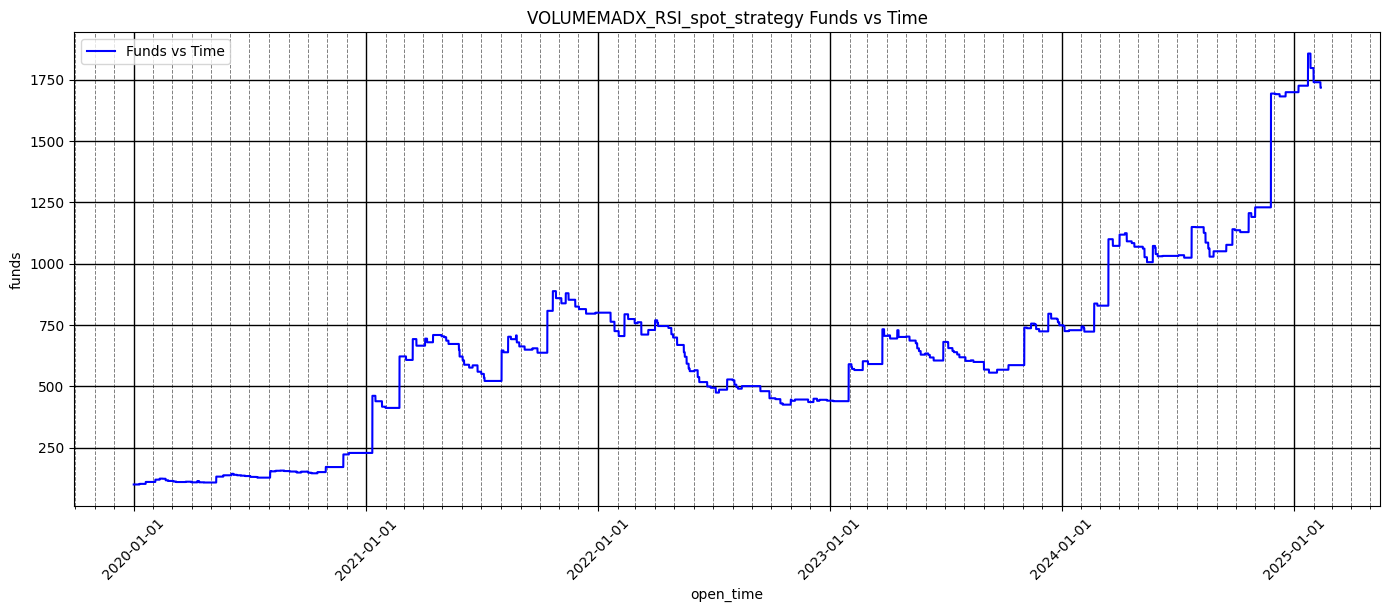

In [5]:
values = best_params
detailed_true_backtest(df, strategy, **values)

In [6]:
plot_strategy_signals(df, strategy,**best_params)

Final funds: 1328.6820760064136
Total trades: 1
Win trades: 1
Lose trades: 0
Max trade rate: 13.286820760064135
Min trade rate: 1
Max win streak: 1
Max lose streak: 0
Max drawdown: 100


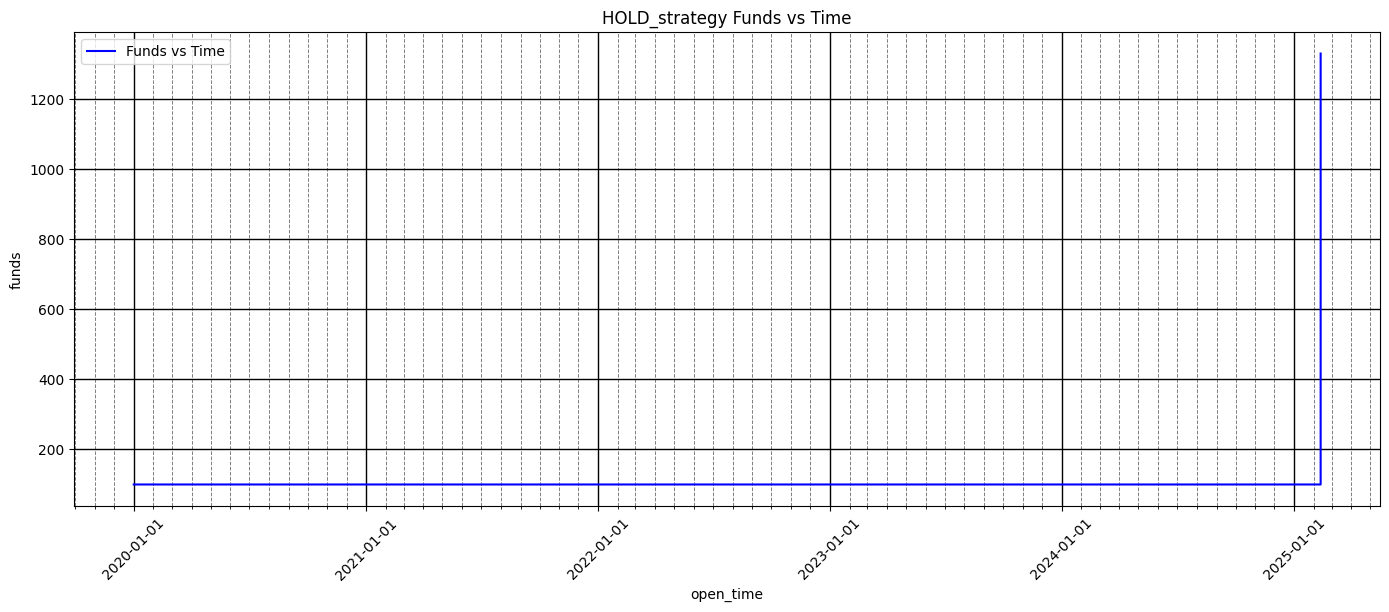

In [8]:
values = {}
detailed_backtest(df, HOLD_strategy, **values)